In [1]:
import pandas as pd
import numpy as np
import re

# random forest
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# tree viz
from sklearn import tree
from sklearn.tree import _tree
import pydotplus
from IPython.display import Image
from os import system

Utility functions

In [2]:
# utilitiy function to print out the accuracy for the predictions
def print_accuracy_report(y_test, y_pred, print_accuracy=True, print_cm=True, print_cr=True):
    if print_accuracy:
        print("="*40)
        print('accuracy: {:.4f}'.format(accuracy_score(y_test, y_pred)))
        
    if print_cm:
        cm = confusion_matrix(y_test, y_pred)
        df_cm = pd.DataFrame(cm, columns = ['predicted - poisonous', 'predicted - edible'])
        df_cm.index=['actual - poisonous', 'actual - edible']
        print("="*40)
        print("confusion matrix")
        print(df_cm)
    
    if print_cr:
        print("="*40)
        print("classification report")
        print(classification_report(y_test, y_pred, 
                                    target_names=['actual - poisonous', 'actual - edible']))

# lookup for the features
features = ['edibility', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor', 
            'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape', 
            'stalk-root', 'stalk-surface-above-ring', 'stalk-surface-below-ring', 
            'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-type', 'veil-color', 
            'ring-number', 'ring-type', 'spore-print-color', 'population', 'habitat']

Data loading & pre-processing

In [3]:
# data loading
df = pd.read_csv('./data/agaricus-lepiota.data.csv', 
                 header=None, names=features)

# recoding categorical variables into one hot encoding
# create feature sets and labels
X = pd.get_dummies(df.iloc[:,1:])
y = df['edibility'].map(lambda x: 0 if x == 'p' else 1)

# creat training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=424242)

# sanity check
# check how many mushrooms are edible, looks like the classes are pretty balanced
print('percentage of edible mushrooms: {:.2f}%'.format(y.mean()*100))

percentage of edible mushrooms: 51.80%


Train a random forest classfier

In [4]:
# build a classifier
clf = RandomForestClassifier(n_estimators=20, max_depth=3, random_state=328919475)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# check the accuracy
print_accuracy_report(y_test, y_pred)

accuracy: 0.9802
confusion matrix
                    predicted - poisonous  predicted - edible
actual - poisonous                   1267                  50
actual - edible                         3                1361
classification report
                    precision    recall  f1-score   support

actual - poisonous       1.00      0.96      0.98      1317
   actual - edible       0.96      1.00      0.98      1364

       avg / total       0.98      0.98      0.98      2681



Important features

In [5]:
# top 5 important features
feature_weights = sorted(list(zip(X.columns, clf.feature_importances_)), 
                         key=lambda x:x[1], reverse=True)
feature_weights[:5]

[('odor_n', 0.14429465065483144),
 ('gill-size_b', 0.088443385614706965),
 ('stalk-surface-above-ring_k', 0.080550557767488998),
 ('odor_f', 0.067859523438371289),
 ('spore-print-color_h', 0.062261504494746857)]

Tree visualization

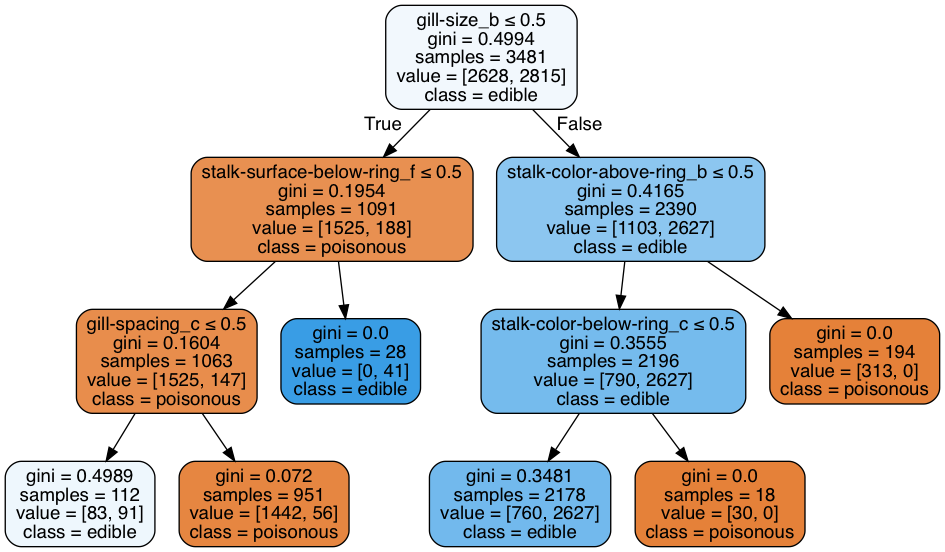

In [6]:
# take a look at a tree directly from Jupyter notebook
idx = 1
dot_data = tree.export_graphviz(clf.estimators_[idx], out_file=None, 
                                feature_names=X.columns,  
                                class_names=['poisonous', 'edible'],  
                                filled=True, rounded=True,  
                                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())  

In [10]:
# export all trees to png or json
def export_json(decision_tree, filename, feature_names=None):
    """
    Code adapted from Peter Prettenhofer at http://bl.ocks.org/pprett/3813537
    
    Export a decision tree in JSON format.

    This function generates a JSON representation of the decision tree,
    which is then written into `out_file`. Once exported, graphical renderings
    can be generated using, for example::

        $ dot -Tps tree.dot -o tree.ps      (PostScript format)
        $ dot -Tpng tree.dot -o tree.png    (PNG format)

    Parameters
    ----------
    decision_tree : decision tree classifier
        The decision tree to be exported to JSON.

    out : file object or string, optional (default=None)
        Handle or name of the output file.

    feature_names : list of strings, optional (default=None)
        Names of each of the features.

    Returns
    -------
    out_file : file object
        The file object to which the tree was exported.  The user is
        expected to `close()` this object when done with it.

    Examples
    --------
    >>> from sklearn.datasets import load_iris
    >>> from sklearn import tree

    >>> clf = tree.DecisionTreeClassifier()
    >>> iris = load_iris()

    >>> clf = clf.fit(iris.data, iris.target)
    >>> import tempfile
    >>> out_file = tree.export_json(clf, out_file=tempfile.TemporaryFile())
    >>> out_file.close()
    """

    def arr_to_py(arr):
        arr = arr.ravel()
        wrapper = float
        if np.issubdtype(arr.dtype, np.int):
            wrapper = int
        return list(map(wrapper, arr.tolist()))
    
    def get_class(tree, node_id):
        p, e = tree.value[node_id][0][0], tree.value[node_id][0][1]
        return 'poisonous' if p > e else 'edible'
    
    def parse_feature(feature):
        m = re.match('(.*)_(.*)', feature)
        return 'Is ' + m.group(1) + ' ' + m.group(2) + '?'
        
    def node_to_str(tree, node_id, node_type):
        """
        node_type: 0: root, 1: left child, 2: right child
        """
        node_repr = '"error": %.4f, "samples": %d, "value": %s' \
                    % (tree.impurity[node_id],
                       tree.n_node_samples[node_id],
                       arr_to_py(tree.value[node_id][0]))
        
        label = '' if node_type == 0 else ('no -> ' if node_type == 1 else 'yes -> ')
        
        if tree.children_left[node_id] != _tree.TREE_LEAF:
            if feature_names is not None:
                feature = feature_names[tree.feature[node_id]]
            else:
                feature = "X[%s]" % tree.feature[node_id]
            
            label = '"name": "'+ label +'%s"' % (parse_feature(feature))
            # label = '"name": '+ label +'"%s <= %.2f"' % (feature, tree.threshold[node_id])
            node_type = '"type": "split"'
        else:
            node_type = '"type": "leaf"'
            label = '"name": "%s"' % get_class(tree, node_id)
        node_repr = ", ".join((node_repr, label, node_type))
        # print(node_repr)
        return node_repr

    def recurse(tree, node_id, node_type, parent=None):
        if node_id == _tree.TREE_LEAF:
            raise ValueError("Invalid node_id %s" % _tree.TREE_LEAF)

        left_child = tree.children_left[node_id]
        right_child = tree.children_right[node_id]

        # Open node with description
        out_file.write('{%s' % node_to_str(tree, node_id, node_type))

        # write children
        if left_child != _tree.TREE_LEAF:  # and right_child != _tree.TREE_LEAF
            out_file.write(', "children": [')
            recurse(tree, left_child, 1, node_id)
            out_file.write(', ')
            recurse(tree, right_child, 2, node_id)
            out_file.write(']')

        # close node
        out_file.write('}')
        
    with open(filename, 'w') as out_file:
        if isinstance(decision_tree, _tree.Tree):
            recurse(decision_tree, 0, 0)
        else:
            recurse(decision_tree.tree_, 0, 0)

def export_trees(export_type, feature_names):
    for idx, clf_dt in enumerate(clf.estimators_):
        if export_type == 'image':
            # tree viz
            filename = 'tree' + str(idx) + '.png'
            tree.export_graphviz(clf_dt, out_file='tree.dot', 
                                 feature_names=feature_names,
                                 class_names=['poisonous', 'edible'],
                                 filled=True, rounded=True, impurity=False,
                                 special_characters=True)
            system('dot -Tpng tree.dot -o ' + filename)
        elif export_type == 'json':
            filename = 'tree' + str(idx) + '.json'
            export_json(clf_dt, filename, feature_names=feature_names)

In [12]:
export_trees('image', X.columns)

In [9]:
# dir(clf.estimators_[0].tree_)
# clf.estimators_[0].tree_.max_n_classes